In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import copy
from scipy import sparse

# import modules 
from matplotlib_venn import venn3,venn3_circles 
from matplotlib import pyplot as plt 

In [2]:
import matplotlib
matplotlib.use('Agg')
from matplotlib import gridspec
from matplotlib.colors import Normalize
from matplotlib import cm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
norm = matplotlib.colors.Normalize(vmin=0, vmax=20)

import matplotlib.font_manager as font_manager
font_dirs = ['/project/elkabetz_lab_data/tools/PythonFonts/', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
matplotlib.rcParams['font.family'] = 'arial'
import pickle as pkl

In [3]:
from lik_models import *
from helper_funcs import *
from plotting_funcs import *
from mcmc_data import *

In [4]:
mcmc = mcmc_data(count_matrix_fn='/project/single_cell/Daniel/Transcriptional_Cascades/scripts/Transcriptional_Cascades/data/e13_5_mouse_forebrain_neuron_diff.2.raw_count_matrix.tsv',
                          pkl_dir='/project/single_cell/Daniel/Transcriptional_Cascades/scripts/Transcriptional_Cascades/outputs_full/e13_5_forebrain_dorsal_2/',
                          tfs_fn='/project/single_cell/Transcriptional_Cascades/data/mouse_transcription_factors_zhou_et_al.txt',
                          name='e13.5 Mouse Cortical Neuron')

Loading Count Matrix...
Normalizing Count Matrix...


In [5]:
#load in all pkls
mcmc.load_pkls(sub_tfs=False)

#get best fitting genes
mcmc.get_top_genes(n_top=50,sub_tf=False)

Loading pkls...
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500


In [6]:
fit_types = {}
non_unif_fits = {}
for gene in mcmc.inflection_points:
    if mcmc.best_fits[gene] != 'uniform':
        non_unif_fits[gene] = mcmc.inflection_points[gene]
    else:
        fit_types[gene] = "uniform"
for type_ in ['sig down','sig up','transient up','transient down']:
    print(type_)
    for gene in [y[0] for y in sorted(non_unif_fits.items(),key = lambda x:get_mode(x[1],n_bins=50))]:
        if type_ is not None:
            keep = False
            if type_ == 'sig up':
                if mcmc.best_fits[gene] == 'sigmoidal':
                    if np.mean(mcmc.inflection_point_derivs[gene]) > 0:
                        fit_types[gene] = 'sig up'
                elif mcmc.best_fits[gene] == 'double sigmoidal':
                    if (np.mean(mcmc.inflection_point_derivs[gene]) > 0) & (np.mean(mcmc.inflection_point_derivs_2[gene]) > 0):
                        fit_types[gene] = 'sig up'
            elif type_ == 'sig down':
                if mcmc.best_fits[gene] == 'sigmoidal':
                    if np.mean(mcmc.inflection_point_derivs[gene]) < 0:
                        fit_types[gene] = 'sig down'
                elif mcmc.best_fits[gene] == 'double sigmoidal':
                    if (np.mean(mcmc.inflection_point_derivs[gene]) < 0) & (np.mean(mcmc.inflection_point_derivs_2[gene]) < 0):
                        fit_types[gene] = 'sig down'
            elif type_ == 'transient up':
                if mcmc.best_fits[gene] == 'gauss':
                    fit_types[gene] = 'transient up'
                if mcmc.best_fits[gene] == 'double sigmoidal':
                    if (np.mean(mcmc.inflection_point_derivs[gene]) > 0) & (np.mean(mcmc.inflection_point_derivs_2[gene]) < 0):
                        fit_types[gene] = 'transient up'
            elif type_ == 'transient down':
                if mcmc.best_fits[gene] == 'double sigmoidal':
                    if (np.mean(mcmc.inflection_point_derivs[gene]) < 0) & (np.mean(mcmc.inflection_point_derivs_2[gene]) > 0):
                        fit_types[gene] = 'transient down'

sig down
sig up
transient up
transient down


In [7]:
fit_types_fixed = {}
for gene in fit_types:
    fit_types_fixed[gene.replace("|",".")] = fit_types[gene]
de_genes_our_method = [x for x in fit_types_fixed if fit_types_fixed[x] != "uniform"]

In [8]:
tradeseq_results = pd.read_csv("/project/single_cell/Transcriptional_Cascades/Revision/tradeseq/e13.5_forebrain_dorsal_traj_adata_g23.tradeseq.assorRes.csv",index_col=0)
monocle_results = pd.read_csv("/project/single_cell/Transcriptional_Cascades/Revision/monocle/monocle_test_res.csv",index_col=0)

In [9]:
len(fit_types)

9530

In [10]:
tradeseq_de_genes = list(tradeseq_results[tradeseq_results["fdr"] < 0.05].index)
monocle_de_genes = list(monocle_results[monocle_results["q_value"] < 0.05].index)

In [11]:
len(monocle_de_genes),len(tradeseq_de_genes),len(set(tradeseq_de_genes).intersection(set(monocle_de_genes)))

(4270, 4256, 3163)

In [12]:
tradeseq_results["deg_our_method"] = [True if x in de_genes_our_method else False for x in tradeseq_results.index]

In [13]:
len(de_genes_our_method),len(set(de_genes_our_method).intersection(set(monocle_de_genes))),len(set(de_genes_our_method).intersection(set(tradeseq_de_genes)))

(722, 721, 718)

In [14]:
tradeseq_results_sort = tradeseq_results.sort_values(by="waldStat",ascending=False)

In [15]:
tradeseq_results_sort[tradeseq_results_sort["deg_our_method"]==False][:50]

,waldStat,df,pvalue,meanLogFC,fdr,deg_our_method
ENSMUSG00000061787.Rps17,158.813880,2.0,0.0,0.101893,0.0,False
ENSMUSG00000029614.Rpl6,152.624988,2.0,0.0,0.097407,0.0,False
ENSMUSG00000015217.Hmgb3,147.775720,2.0,0.0,0.277251,0.0,False
ENSMUSG00000058267.Mrps14,145.092119,2.0,0.0,0.296571,0.0,False
ENSMUSG00000058546.Rpl23a,141.610131,2.0,0.0,0.092875,0.0,False
ENSMUSG00000034892.Rps29,141.274218,2.0,0.0,0.112845,0.0,False
ENSMUSG00000024097.Srsf7,140.864221,2.0,0.0,0.691150,0.0,False
ENSMUSG00000008683.Rps15a,134.833415,2.0,0.0,0.144909,0.0,False
ENSMUSG00000066705.Fxyd6,132.953152,2.0,0.0,1.375944,0.0,False
ENSMUSG00000024590.Lmnb1,129.703022,2.0,0.0,1.040900,0.0,False


In [16]:
bic_diff = {}
for gene in mcmc.best_fits.keys():
    if mcmc.best_fits[gene] != 'uniform':
        #here, use bic estimate over avg params to sort genes by fit
        bic_diff[gene] = mcmc.bic_avg_params[gene][mcmc.best_fits[gene]]-\
        mcmc.bic_avg_params[gene]['uniform']  

In [17]:
mcmc.poor_fits

{'ENSMUSG00000000001|Gnai3': [],
 'ENSMUSG00000000171|Sdhd': [],
 'ENSMUSG00000000028|Cdc45': [],
 'ENSMUSG00000000253|Gmpr': [],
 'ENSMUSG00000000031|H19': [],
 'ENSMUSG00000000148|Brat1': [],
 'ENSMUSG00000000184|Ccnd2': [],
 'ENSMUSG00000000056|Narf': [],
 'ENSMUSG00000000276|Dgke': [],
 'ENSMUSG00000000058|Cav2': [],
 'ENSMUSG00000000194|Gpr107': [],
 'ENSMUSG00000000078|Klf6': [],
 'ENSMUSG00000000278|Scpep1': [],
 'ENSMUSG00000000142|Axin2': [],
 'ENSMUSG00000000085|Scmh1': [],
 'ENSMUSG00000000202|Btbd17': [],
 'ENSMUSG00000000088|Cox5a': ['double sigmoidal'],
 'ENSMUSG00000000282|Mnt': [],
 'ENSMUSG00000000167|Pih1d2': ['double sigmoidal'],
 'ENSMUSG00000000127|Fer': [],
 'ENSMUSG00000000223|Drp2': [],
 'ENSMUSG00000000131|Xpo6': [],
 'ENSMUSG00000000295|Hddc2': [],
 'ENSMUSG00000000134|Tfe3': [],
 'ENSMUSG00000000247|Lhx2': [],
 'ENSMUSG00000000149|Gna12': [],
 'ENSMUSG00000000168|Dlat': [],
 'ENSMUSG00000000296|Tpd52l1': [],
 'ENSMUSG00000000301|Pemt': [],
 'ENSMUSG0000000030

In [18]:
mcmc.bic_avg_params['ENSMUSG00000041841|Rpl37']['sigmoidal']-mcmc.bic_avg_params['ENSMUSG00000041841|Rpl37']['uniform']

-27.03653589084206

In [19]:
sorted(bic_diff.items(),key=lambda x:x[1])

[('ENSMUSG00000019874|Fabp7', -5302.81324541037),
 ('ENSMUSG00000027967|Neurog2', -4787.775802003149),
 ('ENSMUSG00000062380|Tubb3', -4615.642488893168),
 ('ENSMUSG00000049775|Tmsb4x', -4244.869868703952),
 ('ENSMUSG00000048001|Hes5', -4189.088026521713),
 ('ENSMUSG00000037984|Neurod6', -4106.132222054455),
 ('ENSMUSG00000063632|Sox11', -3559.2094828293993),
 ('ENSMUSG00000021087|Rtn1', -3446.5932511825204),
 ('ENSMUSG00000079523|Tmsb10', -3444.264376369445),
 ('ENSMUSG00000026385|Dbi', -3273.9833999568327),
 ('ENSMUSG00000035551|Igfbpl1', -2603.150182869792),
 ('ENSMUSG00000038255|Neurod2', -2588.5600533491343),
 ('ENSMUSG00000017390|Aldoc', -2332.8313318429837),
 ('ENSMUSG00000045136|Tubb2b', -2320.8986967642995),
 ('ENSMUSG00000090223|Pcp4', -2125.3214913263655),
 ('ENSMUSG00000021453|Gadd45g', -2041.0993081135825),
 ('ENSMUSG00000053192|Mllt11', -1931.7889848318928),
 ('ENSMUSG00000022658|Tagln3', -1902.7189265651232),
 ('ENSMUSG00000029838|Ptn', -1891.7483958861776),
 ('ENSMUSG000

In [20]:
tradeseq_results_sort[:50]

,waldStat,df,pvalue,meanLogFC,fdr,deg_our_method
ENSMUSG00000079523.Tmsb10,4333.769650,2.0,0.0,0.571797,0.0,True
ENSMUSG00000063632.Sox11,2926.872154,2.0,0.0,1.927025,0.0,True
ENSMUSG00000062380.Tubb3,2813.648141,2.0,0.0,2.380423,0.0,True
ENSMUSG00000045136.Tubb2b,2490.361284,2.0,0.0,0.524981,0.0,True
ENSMUSG00000021087.Rtn1,2412.560128,2.0,0.0,0.954216,0.0,True
ENSMUSG00000029580.Actb,2255.097288,2.0,0.0,0.723365,0.0,True
ENSMUSG00000026385.Dbi,2163.302166,2.0,0.0,1.450462,0.0,True
ENSMUSG00000019874.Fabp7,2108.418026,2.0,0.0,2.791125,0.0,True
ENSMUSG00000049775.Tmsb4x,1964.883036,2.0,0.0,0.883197,0.0,True
ENSMUSG00000035551.Igfbpl1,1812.710374,2.0,0.0,2.392065,0.0,True


In [21]:
set(de_genes_our_method) - set(monocle_de_genes)

{'ENSMUSG00000097545.Mir124a-1hg'}

In [22]:
set(de_genes_our_method) - set(tradeseq_de_genes)

{'ENSMUSG00000020422.Tns3',
 'ENSMUSG00000040907.Atp1a3',
 'ENSMUSG00000097296.Gm26532',
 'ENSMUSG00000097545.Mir124a-1hg'}

In [23]:
%matplotlib inline

In [24]:
tradeseq_results = tradeseq_results[~np.isnan(tradeseq_results["waldStat"])]
tradeseq_results = tradeseq_results.sort_values(by='waldStat',ascending=False)

In [25]:
idx = 0
cum_sum = []
for gene,degour_method in zip(tradeseq_results.index,tradeseq_results["deg_our_method"]):
    if degour_method == True:
        idx += 1
    cum_sum.append(idx)
tradeseq_results['cum_sum'] = cum_sum
tradeseq_results['cum_sum_perc'] = tradeseq_results['cum_sum']/max(cum_sum)

In [26]:
cum_sum_perc = tradeseq_results['cum_sum_perc']
for i in range(len(tradeseq_results['cum_sum_perc'])):
    if cum_sum_perc[i] > 0.9:
        print(i, cum_sum[i])
        break

994 649


Text(0, 0.5, '% Genes non-uniform fit with lower rank')

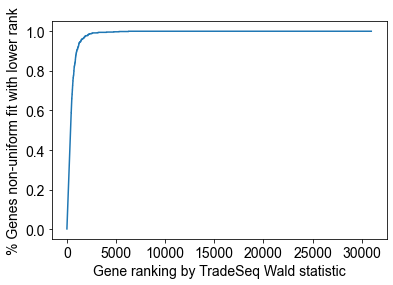

In [27]:
plt.plot(range(len(tradeseq_results)),tradeseq_results['cum_sum_perc'])
plt.xlabel('Gene ranking by TradeSeq Wald statistic',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('% Genes non-uniform fit with lower rank',fontsize=14)

In [28]:
tradeseq_results_sig = tradeseq_results[tradeseq_results['fdr'] < 0.05]

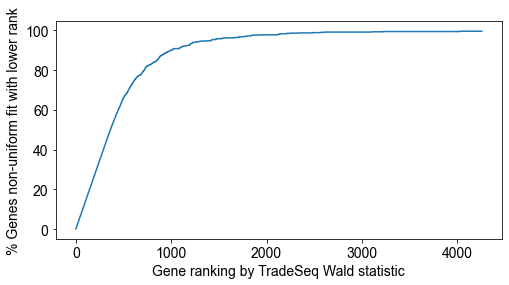

In [29]:
fig = plt.figure(figsize=(8,4))
plt.plot(range(len(tradeseq_results_sig)),tradeseq_results_sig['cum_sum_perc'])
plt.xlabel('Gene ranking by TradeSeq Wald statistic',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('% Genes non-uniform fit with lower rank',fontsize=14)
plt.yticks([0,0.2,0.4,0.6,0.8,1],['0','20','40','60','80','100'])
plt.savefig('/project/single_cell/Transcriptional_Cascades/Revision/figures/rank_percent_plot_tradeseq.pdf',bbox_inches='tight')

In [30]:
monocle_results = monocle_results[monocle_results['status']=="OK"]
monocle_results = monocle_results.sort_values(by='morans_test_statistic',ascending=False)

In [31]:
monocle_results["deg_our_method"] = [True if x in de_genes_our_method else False for x in monocle_results.index]

In [32]:
idx = 0
cum_sum = []
for gene,degour_method in zip(monocle_results.index,monocle_results["deg_our_method"]):
    if degour_method == True:
        idx += 1
    cum_sum.append(idx)
monocle_results['cum_sum'] = cum_sum
monocle_results['cum_sum_perc'] = monocle_results['cum_sum']/max(cum_sum)

In [33]:
monocle_results_sig = monocle_results[monocle_results['q_value'] < 0.05]

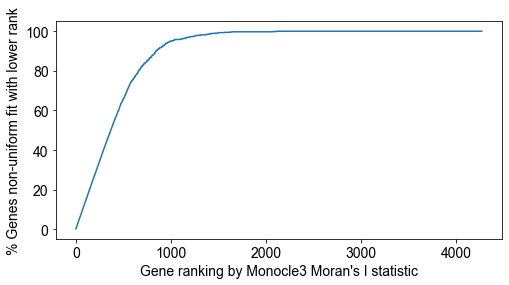

In [34]:
fig = plt.figure(figsize=(8,4))
plt.plot(range(len(monocle_results_sig)),monocle_results_sig['cum_sum_perc'])
plt.xlabel("Gene ranking by Monocle3 Moran's I statistic",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('% Genes non-uniform fit with lower rank',fontsize=14)
plt.yticks([0,0.2,0.4,0.6,0.8,1],['0','20','40','60','80','100'])
plt.savefig('/project/single_cell/Transcriptional_Cascades/Revision/figures/rank_percent_plot_monocle3.pdf',bbox_inches='tight')

Text(0, 0.5, '% Genes non-uniform fit with lower rank')

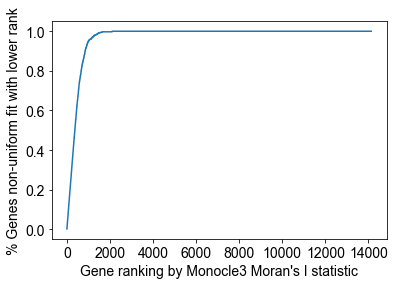

In [34]:
plt.plot(range(len(monocle_results)),monocle_results['cum_sum_perc'])
plt.xlabel("Gene ranking by Monocle3 Moran's I statistic",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('% Genes non-uniform fit with lower rank',fontsize=14)

In [35]:
monocle_results_sig = monocle_results[monocle_results['q_value'] < 0.05]

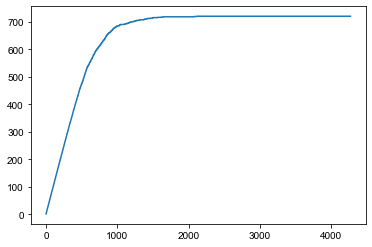

In [36]:
plt.plot(range(len(monocle_results_sig)),monocle_results_sig['cum_sum'])

In [37]:
monocle_specific = len(set(monocle_de_genes)-set(de_genes_our_method)-set(tradeseq_de_genes))
tradeseq_specific = len(set(tradeseq_de_genes)-set(de_genes_our_method)-set(monocle_de_genes))
shared_monocle_tradeseq = len(set(tradeseq_de_genes).intersection(monocle_de_genes)-set(de_genes_our_method))
our_method_specific = len(set(de_genes_our_method)-set(monocle_de_genes)-set(tradeseq_de_genes))
shared_monocle_ourmethod = len(set(de_genes_our_method).intersection(monocle_de_genes)-set(tradeseq_de_genes))
shared_tradeseq_ourmethod = len(set(de_genes_our_method).intersection(tradeseq_de_genes)-set(monocle_de_genes))
shared_all = len(set(de_genes_our_method).intersection(tradeseq_de_genes).intersection(set(monocle_de_genes)))

In [39]:
print((monocle_specific, tradeseq_specific, shared_monocle_tradeseq, 
                 our_method_specific,shared_monocle_ourmethod,shared_tradeseq_ourmethod,
                 shared_all))

(1104, 1093, 2445, 1, 3, 0, 718)


In [40]:
sns.color_palette('Spectral')

[(0.8853517877739331, 0.3190311418685121, 0.29042675893886966),
 (0.9873125720876587, 0.6473663975394078, 0.3642445213379469),
 (0.9971549404075356, 0.9118031526336025, 0.6010765090349866),
 (0.9288735101883892, 0.9715494040753557, 0.6380622837370243),
 (0.6334486735870821, 0.8521337946943485, 0.6436755094194541),
 (0.2800461361014994, 0.6269896193771626, 0.7024221453287197)]

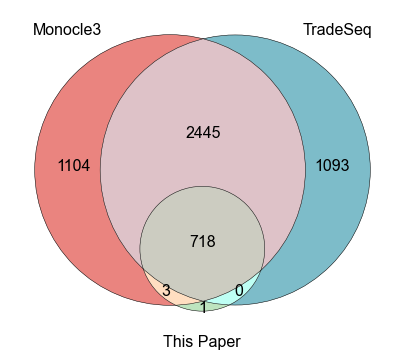

In [46]:
# depict venn diagram 
plt.figure(figsize=(7,7))
subsets = (monocle_specific, tradeseq_specific, 1800, 
       50,shared_monocle_ourmethod,shared_tradeseq_ourmethod,
       shared_all)

venn_plot = venn3(subsets,("Monocle3","TradeSeq","\nThis Paper"),
                  set_colors=(sns.color_palette('Spectral')[0],sns.color_palette('Spectral')[5],sns.color_palette('Spectral')[4]), 
                  alpha=0.7)
for text in venn_plot.set_labels:
    text.set_fontsize(16)
for x in range(len(venn_plot.subset_labels)):
    if venn_plot.subset_labels[x] is not None:
        venn_plot.subset_labels[x].set_fontsize(16)

venn_plot.get_label_by_id('100').set_text(str(monocle_specific))
venn_plot.get_label_by_id('110').set_text(str(shared_monocle_tradeseq)+'\n\n\n')
venn_plot.get_label_by_id('010').set_text(str(tradeseq_specific))
venn_plot.get_label_by_id('101').set_text(str(shared_monocle_ourmethod))
venn_plot.get_label_by_id('111').set_text("\n\n\n\n"+str(shared_all))
venn_plot.get_label_by_id('011').set_text(str(shared_tradeseq_ourmethod))
venn_plot.get_label_by_id('001').set_text(str(our_method_specific))

# add outline 
venn3_circles(subsets,linewidth=0.5)  

plt.savefig('/project/single_cell/Transcriptional_Cascades/Revision/figures/venn_diagram_monocle_tradeseq.pdf',bbox_inches='tight')
plt.show()